In [1]:
#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

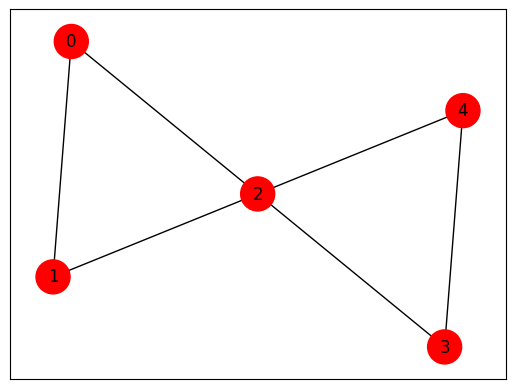

In [2]:
# Generating the butterfly graph with 5 nodes
# node의 갯수 설정 
n     = 5
# node의 점들의 번호를 만듬
V     = np.arange(0,n,1)
# node들을 연결하는 edge들을 설정함 각각 node1, node2, weight를 의미
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)]

# networks package의 Graph 모듈을 불러옴
# dictionary의 형태로 각 node가 어떤 node와 어떤 weight으로 연결되어 있는 지를 저장함 
G     = nx.Graph()
# node들을 추가
G.add_nodes_from(V)
# edge들을 추가
G.add_weighted_edges_from(E)

# Generate plot of the Graph
# node를 빨간색으로 설정
colors       = ['r' for node in G.nodes()]
# 상자 태두리 설정
default_axes = plt.axes(frameon=True)
# layout 설정
pos          = nx.spring_layout(G)
#그래프 그리기
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

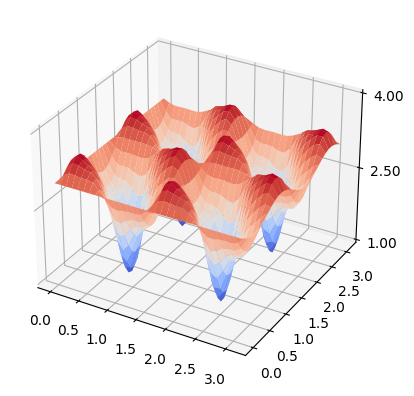


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [3]:
# Evaluate the function
# gamma와 beta를 고르기 위해서 step size를 설정하여 gamma와 beta의 특정 범위의 array를 만든다.
step_size   = 0.1
a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
# 3차원 그림을 그리기 위한 meshgrid 설정
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

# gamma와 beta의 값을 결정하는데 사용할 함수, 이 함수의 값이 최대가 되게 하는 gamma, beta 값을 찾는다.
# 현재 계산하려 하는 문제의 기댓값에 대한 이론적인 analytic function
# M_p = F_p(gamma*, beta*) 여기서 p는 Trotter 근사를 하는 정도를 의미한다.
F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
# F1이 최대가 되게 하는 index 값을 찾는다. 여러 개가 있을 경우 그중 가장 작은 값
# optimizing을 통해서 얻어야 하는 parameter
# 여기서는 이론적인 함수를 통해서 직접 계산을 진행하고 양자를 사용한 결과와 이론적인 결과를 비교한다. 
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

# index 값에 step_size를 곱해서 해당되는 최적화된 gamma, beta 값을 저장한다. 
gamma  = a[0]*step_size
beta   = a[1]*step_size

# Plot the expetation value F1
# F1 함수를 3D로 시각화
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
# z축 범위 설정
ax.set_zlim(1,4)
# 축의 tick 설정
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

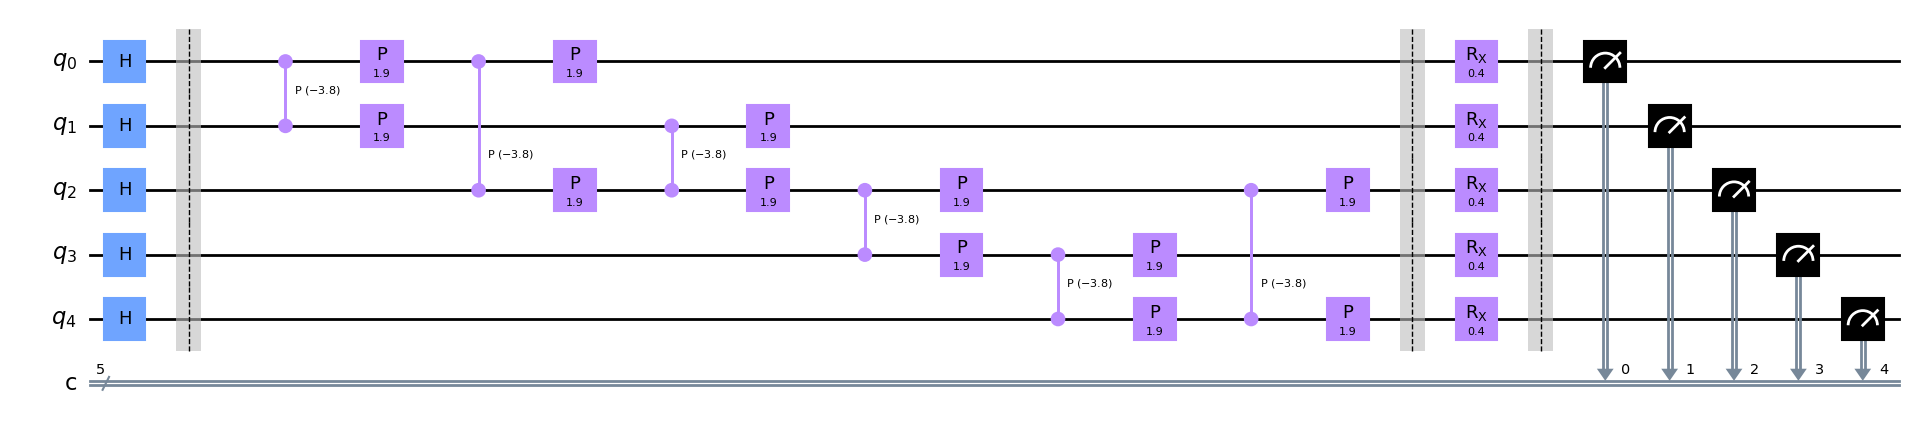

In [12]:
# prepare the quantum and classical resisters
# node의 수만큼 qubit과 그에 대응되는 classical resiter를 준비한다.
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
# 모든 qubit에 대해서 Hadamard gate를 적용하여 unifrom하게 중첩된 상태를 만든다.
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
# problem Hamiltonian H_P에 대응되는 e^(-iH_P*gamma)의 unitary를 표현한 gate들
# H_P는 sum(1/2[Z_connected (X) Z_nodes (X) I_least (X) I_nodes])로 표현된다. (X): Tesor product
# E는 각 edge들이 어떤 node 두개를 연결하고 그 사이의 weight가 얼마인지를 표현한다. (node1, node2, weight)
for edge in E:
    # 연결하는 node 1
    k = edge[0]
    # 연결하는 node 2
    l = edge[1]
    # 두 node에 해당되는 qubit을 gamma만큼 cp gate로 연결
    QAOA.cp(-2*gamma, k, l)
    # 각 node에 해당되는 qubit에 phase gate를 gamma만큼 적용한다.
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)

    
# then apply the single qubit X - rotations with angle beta to all qubits
# mixer Hamiltonian H_B에 대응되는 e^(-iH_B*beta)의 unitary를 표현한 gate들
# H_B는 sum_i (X_i (X) I_i+1 (X) I_i+2 (X) ... (X) I_i+n-1) (여기서 +는 mod n연산, n은 총 node의 수)
QAOA.barrier()
# 모든 qubit들에 rx gate를 적용한다.
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
# 각 quibit을 측정하고 결과를 classiacl register에 저장한다.
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output='mpl', fold = -1)

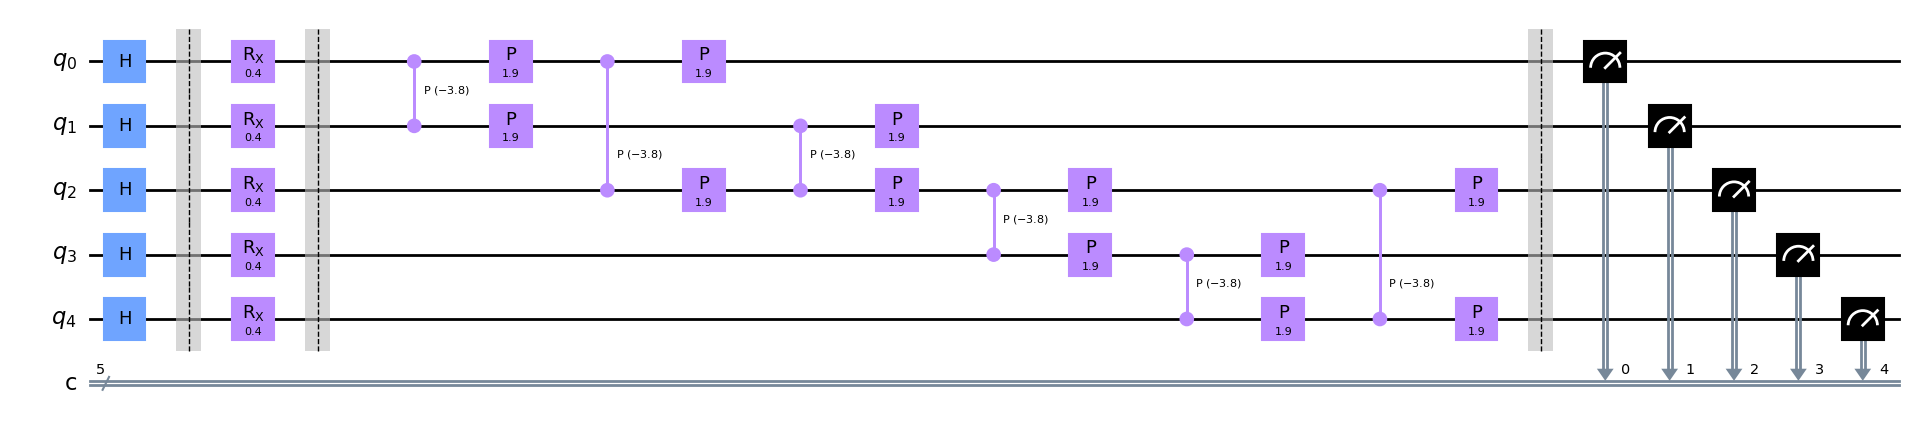

In [4]:
# prepare the quantum and classical resisters
# node의 수만큼 qubit과 그에 대응되는 classical resiter를 준비한다.
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
# 모든 qubit에 대해서 Hadamard gate를 적용하여 unifrom하게 중첩된 상태를 만든다.
QAOA.h(range(len(V)))
QAOA.barrier()
# then apply the single qubit X - rotations with angle beta to all qubits
# mixer Hamiltonian H_B에 대응되는 e^(-iH_B*beta)의 unitary를 표현한 gate들
# H_B는 sum_i (X_i (X) I_i+1 (X) I_i+2 (X) ... (X) I_i+n-1) (여기서 +는 mod n연산, n은 총 node의 수)


# 모든 qubit들에 rx gate를 적용한다.
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis

QAOA.barrier()
# apply the Ising type gates with angle gamma along the edges in E
# problem Hamiltonian H_P에 대응되는 e^(-iH_P*gamma)의 unitary를 표현한 gate들
# H_P는 sum(1/2[Z_connected (X) Z_nodes (X) I_least (X) I_nodes])로 표현된다. (X): Tesor product
# E는 각 edge들이 어떤 node 두개를 연결하고 그 사이의 weight가 얼마인지를 표현한다. (node1, node2, weight)
for edge in E:
    # 연결하는 node 1
    k = edge[0]
    # 연결하는 node 2
    l = edge[1]
    # 두 node에 해당되는 qubit을 gamma만큼 cp gate로 연결
    QAOA.cp(-2*gamma, k, l)
    # 각 node에 해당되는 qubit에 phase gate를 gamma만큼 적용한다.
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)

    
QAOA.barrier()
# 각 quibit을 측정하고 결과를 classiacl register에 저장한다.
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output='mpl', fold = -1)

In [23]:
# Use the IBMQ essex device
# 실제 양자 컴퓨터를 사용하는 경우
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku', group='hanyang-uni', project='hu-students')

backend = provider.get_backend('ibmq_montreal')
shots   = 2048

/tmp/ipykernel_8358/2770977698.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


In [5]:
# aer 시뮬레이터를 사용하는 경우
backend = Aer.get_backend('aer_simulator')
shots   = 2048

In [6]:
# 양자 회로를 시행
job_exp = execute(QAOA, backend=backend, shots=shots)
job_monitor(job_exp)

Job Status: job has successfully run


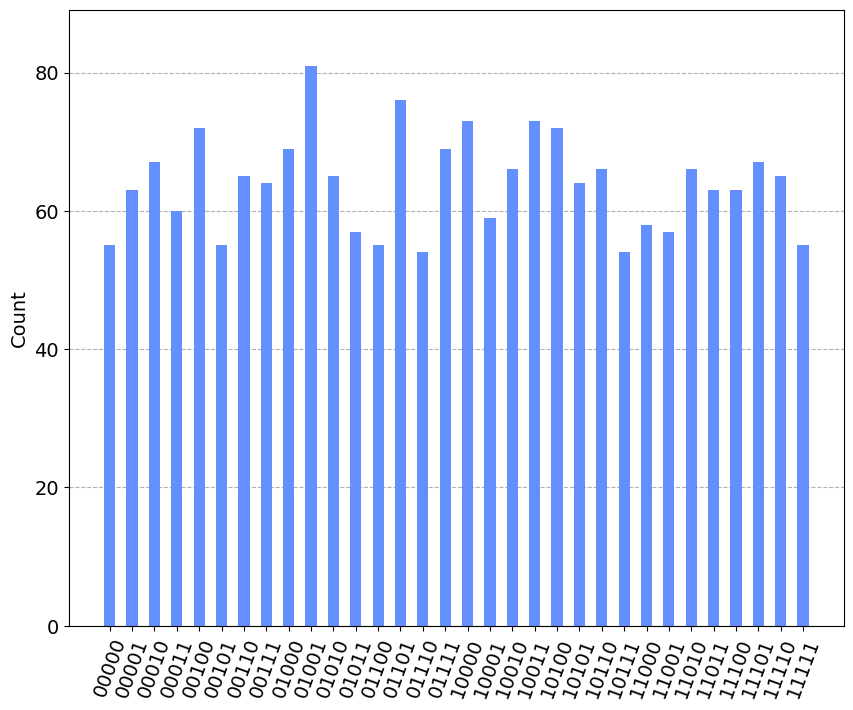

In [7]:
# 양자 회로의 시행 결과
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)

In [8]:
# Compute the value of the cost function
# 최적화에 사용할 cost function
# C(x) = sum_ij (w_ij*x_i*(1-x_j)의 형태로 정의됨
# x는 각 node가 0 이거나 1인 형태를 가지는 list 형식의 값
def cost_function_C(x,G):
    # edge들에 대한 정보를 저장 (node1, node2, weight)
    E = G.edges()
    # 들어온 x (각 node에 대응되는 값)의 크기가 G 그래프의 노드의 수와 같지 않은 경우 nan값을 반환
    if( len(x) != len(G.nodes())):
        return np.nan

    # cost함수 값을 저장
    C = 0
    # 각 edge들에 대해서 연산을 진행
    for index in E:
        # 첫 번째 node
        e1 = index[0]
        # 두 번째 node
        e2 = index[1]
        # 두 node 사이의 weight값
        w      = G[e1][e2]['weight']
        # cost함수에 더해서 계산
        # x list안의 각 node에 해당되는 qubit의 측정값 (0 또는 1)을 통해서 계산
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    # 계산된 cost함수를 반환    
    return C


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 3.03 while the true value is M1 = 3.43 

The approximate solution is x* = 01110 with C(x*) = 4 

The cost function is distributed as: 



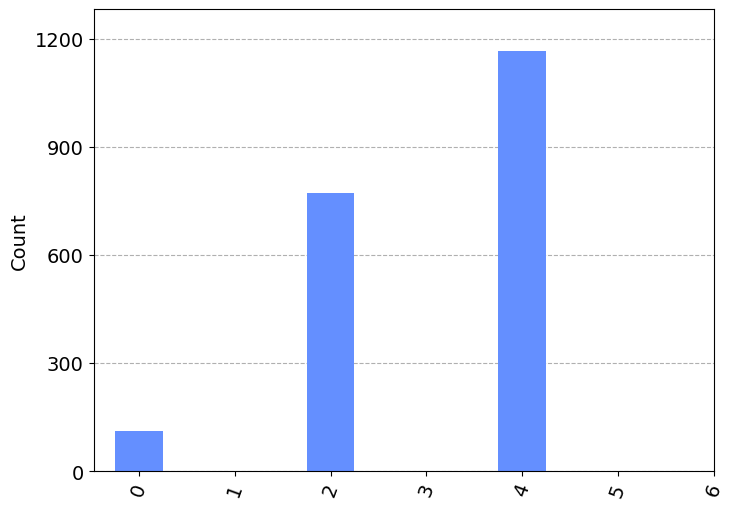

In [9]:
# Evaluate the data from the experiment
# 양자 회로를 통해 얻은 결과를 불러온다.
# dictionary 형태로 이진 bit가 몇번씩 측정되었는지가 저장됨
counts = exp_results.get_counts()

# cost function에 대한 계산 결과를 저장함
avr_C       = 0
max_C       = [0,0]
hist        = {}

# 각 edge에 해당되는 수를 string 형태로 dictinary의 key로 사용, 값은 0으로 설정
for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

# 양자 회로의 결과에서 나온 각 상태들에 대해서 연산
for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    # 결과에서 나온 이진 bit를 각각 0 또는 1의 형태로 나누어 list의 형태로 저장
    x         = [int(num) for num in list(sample)]
    # 주어진 상태에 대한 cost 함수를 계산한다. 
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    # 계산한 cost함수를 그 상태가 측정된 횟수를 곱해서 expectation을 계산 (나중에 shot수로 나누어 계산)
    avr_C     = avr_C    + counts[sample]*tmp_eng
    # cost 함수에서 계산한 값을 반올림하여 정수로 바꾸고 문자열로 바꾸어 key를 만든다.
    # 그리고 그 값이 측정된 횟수를 저장한다.
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    # cost함수가 최대가 되는 값, 즉 원하는 x 값을 얻기 위해서 이전의 최대값과 비교하는 절차
    # list의 0번재 element는 양자상태, 1번째 element는 cost 함수의 값을 저장한다.
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng

# shot수로 나누어 expectation을 계산한다.                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
# 양자 회로를 통해 계산한 값과 실제 최대 값을 비교한다.
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
# 최적의 x에 대한 근사와 그에 대응되는 cost함수의 결과
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
# 각 값에 대응되는 측정이 몇번 일어났는지를 표현하는 histogram
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)